In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


# ****RFM METRİKLERİNİ KULLANARAK K-MEANS METODUYLA MÜŞTERİ SEGMENTASYONU****
Çalışma kapsamında İngiltere merkezli bir perakende şirketinin 01/12/2009 - 09/12/2011 tarihleri arasındaki online satış işlemlerini içeren bir veri seti üzerinde, RFM metriklerinin yanı sıra diğer bazı özellikler de üretilerek, uzaklık temelli K-Means metoduyla müşteri segmentasyonu gerçekleştirilmiştir.

![](https://www.sertacsakarya.com/wp-content/uploads/sertac_segmantasyon.jpg)

**KÜTÜPHANELERİN KURULMASI**

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

**PANDAS AYARLARININ YAPILMASI**

In [3]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 2000)

**VERİ SETİNİN OKUTULMASI**

In [4]:
df = pd.read_csv("../input/online-retail-ii-uci/online_retail_II.csv")

**VERİ SETİNDEKİ DEĞİŞKENLERİN AÇIKLAMASI**
* Invoice: Fatura Numarası (Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder.)
* StockCode: Ürün Kodu (Her bir ürün için eşsizdir.)
* Description: Ürün İsmi
* Quantity: Ürün Adedi (Faturalardaki ürünlerden kaçar tane satıldığını gösterir.)
* InvoiceDate: Fatura Tarihi
* Price: Fatura Fiyatı
* CustomerID: Eşsiz Müşteri Numarası
* Country: Ülke İsmi

**EXPLORATORY DATA ANALYSIS (EDA)**

In [5]:
df.shape

(1067371, 8)

In [6]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

**AYKIRI DEĞERLER**

İade faturalarına ilişkin değerler veri setinden çıkarılmıştır.

In [8]:
df = df[~df["Invoice"].str.contains("C", na=False)]

Miktarı negatif olan değerler iadeleri ifade ettiği için veri setinden çıkarılmıştır.

In [9]:
df = df[(df['Quantity'] > 0)]

**EKSİK DEĞERLER**

Eksik değerler veri setinden doğrudan çıkarılmıştır.

In [10]:
df.dropna(inplace=True)

**FEATURE ENGINEERING**

Veri setine toplam fatura tutarına ilişkin değişken eklenmiştir.

In [11]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

Gözlem tarinin belirlenmesi amacıyla günümüze en yakın fatura tarihi belirlenmiş ve bu tarihten birkaç gün sonrası gözlem tarihi olarak belirlenmiştir.

In [12]:
df["InvoiceDate"].max()

'2011-12-09 12:50:00'

In [13]:
today_date = dt.datetime(2010, 12, 11)

InvoiceDate değişkeninde tip dönüşümü yapılmıştır.

In [14]:

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

Veri setine RFM metrikleri ve diğer bazı değişkenler (satın alınan en pahalı ürün, aynı üründen satın alınan en fazla miktar vb.) eklenmiştir.

In [15]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days, 
                                     'Invoice': lambda num: num.nunique(), 
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum(), 
                                     'Quantity': "max", 
                                     'Price': "max"})

Değişken isimleri daha anlamlı ifadelerle değiştirilmiştir.

In [16]:
rfm.columns = ['recency', 'frequency', 'monetary', 'max_amount_of_item', 'most_expensive_item']

**STANDARTLAŞTIRMA**

Uzaklık temelli yöntemlerde standartlaştırma önemlidir.

In [17]:
sc = MinMaxScaler((0, 1))
rfm_ = sc.fit_transform(rfm)

**OPTİMUM KÜME SAYISININ BELİRLENMESİ**

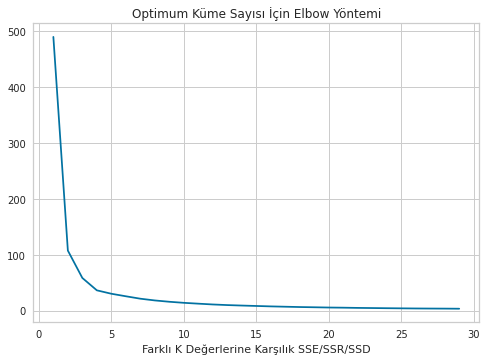

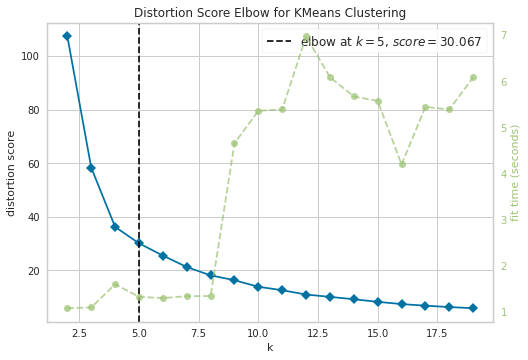

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(rfm_)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme Sayısı İçin Elbow Yöntemi")
plt.show()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(rfm_)
elbow.show()

Optimum küme sayısı dirsek yöntemiyle 5 olarak belirlenmiştir.

**FİNAL MODELİNİN KURULMASI**

Optimum küme sayısı doğrultusunda final modeli kurulmuş olup her bir müşteri için belirlenen sınıf veri setine ayrı bir değişken olarak eklenmiş ve anlamlı olması için sınıf sayılarına 1 eklenmiştir. 

In [28]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(rfm_)
clusters_kmeans = kmeans.labels_
rfm["cluster"] = clusters_kmeans
rfm["cluster"] = rfm["cluster"] + 1
rfm.groupby("cluster").agg(["count","mean","median"]).to_csv("sonuc.csv", index=False)